In [1]:
# --- Basic Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- Text Pre-processing ---
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Set plot style ---
sns.set(style="whitegrid")

# --- NLTK Downloads (only need to run once) ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sgirishkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sgirishkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sgirishkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Step 1: Explanatory Data Analysis (EDA) and Feature Engineering

1.  **Load Data**: Load the consumer complaints dataset.
2.  **Filter Data**: Keep only the rows corresponding to the 4 required product categories.
3.  **Clean Data**: Drop rows with missing complaint narratives.
4.  **Feature Engineering**: Create a numerical `category_id` column from the product names.
5.  **Visualize**: Plot the distribution of the complaints across the categories.

Initial Data Shape: (11535877, 18)

Columns: Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

Shape after filtering and dropping NaNs: (1323496, 18)

Categories and their IDs:
 {'Credit Reporting/Repair': 0, 'Debt collection': 1, 'Mortgage': 2, 'Consumer Loan': 3}


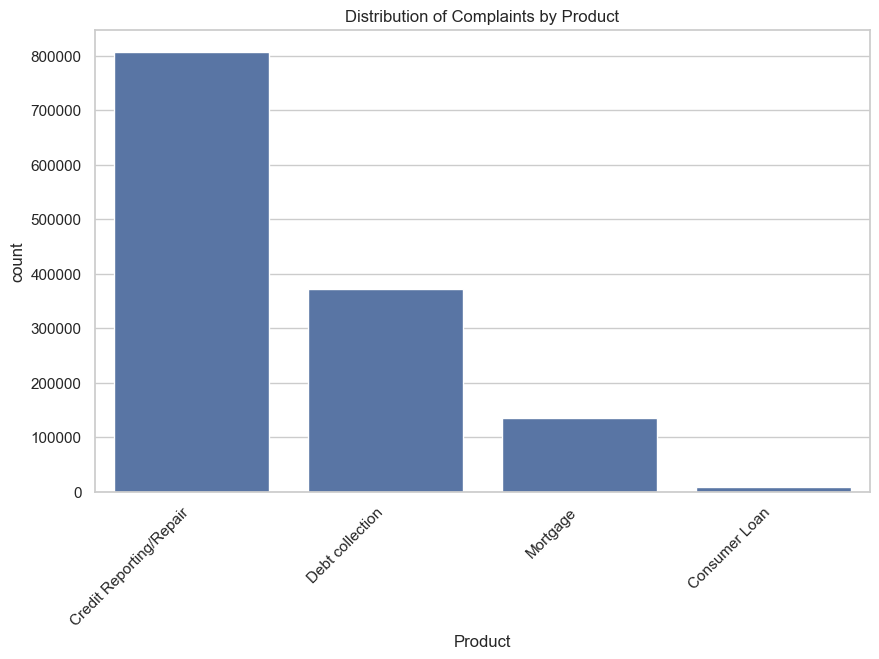

In [3]:
# 1. Load Data
# Download the dataset from: https://www.consumerfinance.gov/data-research/consumer-complaints/
# Click "Download the data" -> CSV. Place it in the same folder as this notebook.
df = pd.read_csv('complaints.csv')

# Print basic info
print("Initial Data Shape:", df.shape)
print("\nColumns:", df.columns)

# 2. Filter Data for the required products
target_products = ['Credit reporting, credit repair services, or other personal consumer reports', 
                   'Debt collection', 'Consumer Loan', 'Mortgage']
df_filtered = df[df['Product'].isin(target_products)].copy()

# 3. Clean Data - Drop rows where the complaint narrative is missing
df_filtered.dropna(subset=['Consumer complaint narrative'], inplace=True)

print("\nShape after filtering and dropping NaNs:", df_filtered.shape)

# Rename the long product name for easier plotting
df_filtered.replace({'Product': {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit Reporting/Repair'}}, inplace=True)

# 4. Feature Engineering: Create a numeric category ID
df_filtered['category_id'] = df_filtered['Product'].factorize()[0]
category_id_df = df_filtered[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

print("\nCategories and their IDs:\n", category_to_id)


# 5. Visualize the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Product', data=df_filtered, order=df_filtered['Product'].value_counts().index)
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=45, ha='right')
plt.show()

### Step 2: Text Pre-processing

We create a function to clean the complaint text. This involves:
1.  Converting to lowercase.
2.  Removing punctuation and numbers.
3.  Tokenizing the text (splitting into words).
4.  Removing common English "stopwords" (like 'the', 'a', 'is').
5.  Lemmatizing words (reducing them to their root form, e.g., 'running' -> 'run').

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenize
    tokens = word_tokenize(text)
    # 4. & 5. Remove stopwords and Lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(processed_tokens)

# Apply the pre-processing function to the complaint narratives
# This can take a few minutes depending on your computer's speed
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(preprocess_text)

print("\nSample of original vs. cleaned narrative:")
print("Original:", df_filtered['Consumer complaint narrative'].iloc[0])
print("Cleaned:", df_filtered['cleaned_narrative'].iloc[0])


Sample of original vs. cleaned narrative:
Original: These are not my accounts.
Cleaned: account


### Step 3: Prepare Data for Models

1.  **Split Data**: Divide the dataset into training (80%) and testing (20%) sets.
2.  **Vectorize Text**: Convert the cleaned text into numerical vectors using `TfidfVectorizer`. TF-IDF measures how important a word is to a document in a collection of documents.

In [11]:
X = df_filtered['cleaned_narrative']
y = df_filtered['category_id']

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# 2. Vectorize text
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to the top 5000 for efficiency
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Training set size: 1058796
Test set size: 264700


### Steps 4 & 5: Model Training, Comparison, and Evaluation

We will train and evaluate three different multi-class classification models:
1.  **Multinomial Naive Bayes**: A classic baseline for text classification.
2.  **Logistic Regression**: A robust and interpretable linear model.
3.  **Linear Support Vector Classifier (LinearSVC)**: Often a top performer for text data.

We will compare them based on accuracy and a detailed classification report.

--- Training Multinomial Naive Bayes ---
Accuracy: 0.8725
Classification Report:
                         precision    recall  f1-score   support

Credit Reporting/Repair       0.90      0.92      0.91    161456
        Debt collection       0.85      0.76      0.80     74380
               Mortgage       0.81      0.95      0.87     26972
          Consumer Loan       0.46      0.29      0.36      1892

               accuracy                           0.87    264700
              macro avg       0.75      0.73      0.73    264700
           weighted avg       0.87      0.87      0.87    264700

--------------------------------------------------
--- Training Logistic Regression ---
Accuracy: 0.9061
Classification Report:
                         precision    recall  f1-score   support

Credit Reporting/Repair       0.92      0.94      0.93    161456
        Debt collection       0.87      0.83      0.85     74380
               Mortgage       0.92      0.93      0.93     26972
       

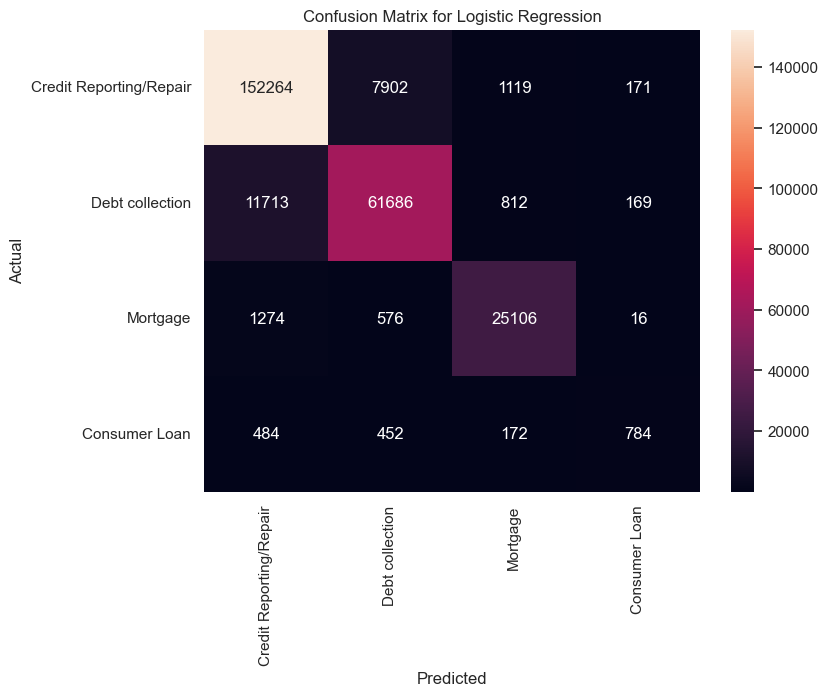

In [14]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVC": LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    # Train the model
    model.fit(X_train_tfidf, y_train)
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=id_to_category.values())
    
    results[name] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("-" * 50)

print("\n--- Model Comparison ---")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Choose the best model (based on accuracy) and show a confusion matrix
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_tfidf)

conf_mat = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id_to_category.values(),
            yticklabels=id_to_category.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

### Step 6: Prediction on New Data

Let's use our best-performing model to predict the category of a new complaint.

In [17]:
def predict_complaint(text, model, vectorizer, id_to_category_map):
    # 1. Pre-process the new text
    cleaned_text = preprocess_text(text)
    # 2. Vectorize the cleaned text
    vectorized_text = vectorizer.transform([cleaned_text])
    # 3. Predict the category ID
    prediction_id = model.predict(vectorized_text)[0]
    # 4. Map the ID back to the category name
    return id_to_category_map[prediction_id]

# Example complaints
new_complaint_1 = "I am having issues with my mortgage payment. The bank increased the interest rate without proper notification."
new_complaint_2 = "A collection agency is harassing me for a debt that I have already paid off. They call me multiple times a day."

print(f"Complaint: '{new_complaint_1}'")
print(f"Predicted Category: {predict_complaint(new_complaint_1, best_model, tfidf_vectorizer, id_to_category)}\n")

print(f"Complaint: '{new_complaint_2}'")
print(f"Predicted Category: {predict_complaint(new_complaint_2, best_model, tfidf_vectorizer, id_to_category)}")

Complaint: 'I am having issues with my mortgage payment. The bank increased the interest rate without proper notification.'
Predicted Category: Mortgage

Complaint: 'A collection agency is harassing me for a debt that I have already paid off. They call me multiple times a day.'
Predicted Category: Debt collection
